## Dependencies

In [1]:
import sqlite3

In [2]:
import pandas as pd
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns

## SQLite

In [3]:
# reading in CSV
retail_df_csv = pd.read_csv("Resources/retail_price_cleaned.csv")

In [4]:
# path and name for database and connecting the db
conn = sqlite3.connect("Resources/pricing_opt.db")
# creating the table "retail" from the dataframe
retail_df_csv.to_sql('retail',conn,index=False,if_exists='replace')

676

In [5]:
query = "SELECT * FROM retail;"
retail_df = pd.read_sql(query,conn)
conn.close()
retail_df.head()

,product_id,product_category_name,month_year,qty_sold,total_price,freight_price,unit_price,product_rating,no_customers,month,...,comp1_price,comp1_prod_rating,comp1_freight_price,comp2_price,comp2_prod_rating,comp2_freight_price,comp3_price,comp3_prod_rating,comp3_freight_price,lag_price
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.100000,45.95,4.0,57,5,...,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,01-06-2017,3,137.85,12.933333,45.95,4.0,61,6,...,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.95
2,bed1,bed_bath_table,01-07-2017,6,275.70,14.840000,45.95,4.0,123,7,...,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.95
3,bed1,bed_bath_table,01-08-2017,4,183.80,14.287500,45.95,4.0,90,8,...,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.95
4,bed1,bed_bath_table,01-09-2017,2,91.90,15.100000,45.95,4.0,54,9,...,89.9,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.95


In [6]:
# retail_df = pd.read_csv("Resources/retail_price_cleaned.csv")

retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             676 non-null    object 
 1   product_category_name  676 non-null    object 
 2   month_year             676 non-null    object 
 3   qty_sold               676 non-null    int64  
 4   total_price            676 non-null    float64
 5   freight_price          676 non-null    float64
 6   unit_price             676 non-null    float64
 7   product_rating         676 non-null    float64
 8   no_customers           676 non-null    int64  
 9   month                  676 non-null    int64  
 10  year                   676 non-null    int64  
 11  seasonality            676 non-null    float64
 12  volume                 676 non-null    int64  
 13  comp1_price            676 non-null    float64
 14  comp1_prod_rating      676 non-null    float64
 15  comp1_

## Model Preparation

In [7]:
retail_df.columns

Index(['product_id', 'product_category_name', 'month_year', 'qty_sold',
       'total_price', 'freight_price', 'unit_price', 'product_rating',
       'no_customers', 'month', 'year', 'seasonality', 'volume', 'comp1_price',
       'comp1_prod_rating', 'comp1_freight_price', 'comp2_price',
       'comp2_prod_rating', 'comp2_freight_price', 'comp3_price',
       'comp3_prod_rating', 'comp3_freight_price', 'lag_price'],
      dtype='object')

In [8]:
# combining 'year' and 'month' to datetime
retail_df['date'] = pd.to_datetime(retail_df[['year', 'month']].assign(day=1))

# Sort the DataFrame by the new datetime column
retail_df = retail_df.sort_values('date')

retail_df.head()

,product_id,product_category_name,month_year,qty_sold,total_price,freight_price,unit_price,product_rating,no_customers,month,...,comp1_prod_rating,comp1_freight_price,comp2_price,comp2_prod_rating,comp2_freight_price,comp3_price,comp3_prod_rating,comp3_freight_price,lag_price,date
389,health7,health_beauty,01-01-2017,1,64.99,11.060000,64.99,3.9,9,1,...,3.9,11.060000,64.99,3.9,11.060000,64.99,3.9,11.060,64.94,2017-01-01
339,health5,health_beauty,01-01-2017,8,2799.20,22.901250,349.90,4.3,9,1,...,4.3,22.901250,349.90,4.3,22.901250,64.99,3.9,11.060,349.85,2017-01-01
438,bed2,bed_bath_table,01-02-2017,2,179.80,13.020000,89.90,3.9,2,2,...,3.9,13.020000,89.90,3.9,13.020000,89.90,3.9,13.020,89.85,2017-02-01
236,garden8,garden_tools,01-02-2017,1,179.99,33.540000,179.99,4.2,3,2,...,4.2,33.540000,179.99,4.2,33.540000,179.99,4.2,33.540,179.94,2017-02-01
58,health9,health_beauty,01-02-2017,11,219.89,11.750909,19.99,4.3,19,2,...,4.3,11.750909,19.99,4.3,11.750909,64.99,3.9,15.348,19.94,2017-02-01


In [9]:
# # Define the number and length of periods
# num_periods = 5
# period_length = 5  # Months per period

# grouped = retail_df.groupby('product_id')

# mse_scores = []

# for group_key, group_data in grouped:
#     # Extract the group's features and target variable
#     features = group_data[['qty_sold', 'total_price', 'freight_price', 'product_rating',
#                            'no_customers', 'seasonality', 'volume', 'comp1_price',
#                            'comp1_prod_rating', 'comp1_freight_price', 'comp2_price',
#                            'comp2_prod_rating', 'comp2_freight_price', 'comp3_price',
#                            'comp3_prod_rating', 'comp3_freight_price', 'lag_price']]

#     target = group_data['unit_price']
    
#     # debug
#     print(f"Product {group_key} - Features Length: {len(features)}, Target Length: {len(target)}")
    
#     # Check if there's enough data for cumulative training
#     if len(features) >= num_periods * period_length:
#         # cumulative training for each group
#         for i in range(1, num_periods + 1):
#             # Define the periods for training and testing
#             train_end = i * period_length
#             test_start = train_end
#             test_end = (i + 1) * period_length
            
#             # Split data into training and testing sets
#             features_train = features[features.index < train_end]
#             target_train = target[target.index < train_end]
#             features_test = features[(features.index >= test_start) & (features.index < test_end)]
#             target_test = target[(target.index >= test_start) & (target.index < test_end)]
            
#             # Train the model
#             model = LinearRegression()
#             model.fit(features_train, target_train)
            
#             # Make predictions
#             y_pred = model.predict(features_test)
            
#             # Evaluate the predictions using Mean Squared Error
#             mse = mean_squared_error(target_test, y_pred)
#             mse_scores.append(mse)
            
#             print(f"Product {group_key}, Period {i} - MSE: {mse:.2f}")
#     else:
#         print(f"Product {group_key} - Not enough data for cumulative training")

# avg_mse = np.mean(mse_scores)
# print(f"Average MSE: {avg_mse:.2f}")

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the window size
window_size = 5

grouped = retail_df.groupby('product_id')

table_data = []
mse_scores = []
predicted_unit_prices = []

for group_key, group_data in grouped:
    # set features and target variable
    features = group_data[['qty_sold', 'total_price', 'freight_price', 'product_rating',
                           'no_customers', 'seasonality', 'volume', 'comp1_price',
                           'comp1_prod_rating', 'comp1_freight_price', 'comp2_price',
                           'comp2_prod_rating', 'comp2_freight_price', 'comp3_price',
                           'comp3_prod_rating', 'comp3_freight_price', 'lag_price']]

    target = group_data['unit_price']
    
    num_samples = len(features)
    predicted_unit_prices = []
    
    # sliding window training and testing
    for i in range(window_size, num_samples):
        # Define the periods for training and testing
        train_start = i - window_size
        train_end = i
        test_start = i
        test_end = i + 1
        
        # Split data into training and testing sets
        features_train = features.iloc[train_start:train_end]
        target_train = target.iloc[train_start:train_end]
        features_test = features.iloc[test_start:test_end]
        target_test = target.iloc[test_start:test_end]
        
        # Train the model
        model = LinearRegression()
        model.fit(features_train, target_train)
        
        # Make predictions
        y_pred = model.predict(features_test)
        
        # Evaluate using Mean Squared Error
        mse = mean_squared_error(target_test, y_pred)
        mse_scores.append(mse)
        
        # Calculate and store the predicted unit prices
        predicted_unit_price = y_pred[0]
        predicted_unit_prices.append(predicted_unit_price)
        
        table_data.append([group_key, i+1, predicted_unit_price, mse])

# Print table
table_headers = ["Product ID", "Sample", "Predicted Price", "MSE"]
print(tabulate(table_data, headers=table_headers, floatfmt=(".0f", ".0f", ".2f", ".2f")))

avg_mse = np.mean(mse_scores)
avg_predicted_unit_price = np.mean(predicted_unit_prices)
print(f"Average MSE: {avg_mse:.2f}")
print(f"Average Predicted Unit Price: {avg_predicted_unit_price:.2f}")


        
#         print(f"Product {group_key}, Sample {i+1} - Predicted Price: {predicted_unit_price:.2f}, MSE: {mse:.2f}")

# avg_mse = np.mean(mse_scores)
# avg_predicted_unit_price = np.mean(predicted_unit_prices)
# print(f"Average MSE: {avg_mse:.2f}")
# print(f"Average Predicted Unit Price: {avg_predicted_unit_price:.2f}")

Product ID      Sample    Predicted Price       MSE
------------  --------  -----------------  --------
bed1                 6              45.95      0.00
bed1                 7              45.95     29.36
bed1                 8              41.98      3.98
bed1                 9              22.08    320.69
bed1                10              40.42      0.18
bed1                11              39.32      0.45
bed1                12              39.89      0.01
bed1                13              39.99      0.00
bed1                14              39.99      0.00
bed1                15              39.99      0.00
bed1                16              39.99      0.56
bed2                 6              89.90      0.00
bed2                 7              89.90      0.00
bed2                 8              89.90      0.00
bed2                 9              89.90      0.00
bed2                10              89.90      0.00
bed2                11              89.90      1.99
bed2        

## Linear Regression

In [11]:
from collections import defaultdict

# Calculate the average predicted unit price and MSE for each product ID
product_avg_predicted_prices = defaultdict(list)
for entry in table_data:
    group_key = entry[0]
    avg_predicted_price = entry[2]
    avg_mse = entry[3]
    product_avg_predicted_prices[group_key].append((avg_predicted_price, avg_mse, entry[1]))

# Find the optimal prices for each product ID based on minimum average MSE
optimal_prices = {}
for group_key, avg_mse_list in product_avg_predicted_prices.items():
    min_avg_mse_entry = min(avg_mse_list, key=lambda x: x[1])
    optimal_price = min_avg_mse_entry[0]
    min_mse = min_avg_mse_entry[1]
    min_mse_sample = min_avg_mse_entry[2]
    optimal_prices[group_key] = (optimal_price, min_mse, min_mse_sample)

# Prepare the final table data for optimal prices
optimal_table_data = []
for group_key, (optimal_price, min_mse, min_mse_sample) in optimal_prices.items():
    optimal_table_data.append([group_key, optimal_price, min_mse, min_mse_sample])

# Print the table for optimal prices
optimal_table_headers = ["Product ID", "Optimal Price", "Min MSE", "Sample with Min MSE"]
print(tabulate(optimal_table_data, headers=optimal_table_headers, floatfmt=(".0f", ".2f", ".2f", ".0f")))


Product ID      Optimal Price    Min MSE    Sample with Min MSE
------------  ---------------  ---------  ---------------------
bed1                    45.95       0.00                      6
bed2                    89.90       0.00                      6
bed3                    85.01       0.01                      9
bed4                    48.18       0.08                      7
computers1              98.73       0.03                      6
computers2              78.22       0.10                      9
computers3             137.33       0.33                      7
computers4             155.10       0.16                      8
computers5              91.69      13.59                      6
computers6             149.90       0.00                      7
consoles1               36.49       0.08                     11
consoles2               33.05       0.09                      9
cool1                   99.99       0.00                      7
cool2                  129.99       0.00

## Random Forest

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Define the window size
window_size = 5

grouped = retail_df.groupby('product_id')

table_data = []
mse_scores = []
predicted_unit_prices = []

for group_key, group_data in grouped:
    # set features and target variable
    features = group_data[['qty_sold', 'total_price', 'freight_price', 'product_rating',
                           'no_customers', 'seasonality', 'volume', 'comp1_price',
                           'comp1_prod_rating', 'comp1_freight_price', 'comp2_price',
                           'comp2_prod_rating', 'comp2_freight_price', 'comp3_price',
                           'comp3_prod_rating', 'comp3_freight_price', 'lag_price']]

    target = group_data['unit_price']
    
    num_samples = len(features)
    predicted_unit_prices = []
    
    # sliding window training and testing
    for i in range(window_size, num_samples):
        # Define the periods for training and testing
        train_start = i - window_size
        train_end = i
        test_start = i
        test_end = i + 1
        
        # Split data into training and testing sets
        features_train = features.iloc[train_start:train_end]
        target_train = target.iloc[train_start:train_end]
        features_test = features.iloc[test_start:test_end]
        target_test = target.iloc[test_start:test_end]
        
                    ## STANDARD SCALING ##
        scaler = StandardScaler()
            # Fitting the scaler
        features_scaler = scaler.fit(features_train)
            # Scaling the feature data
        features_train_scaled = features_scaler.transform(features_train)
        features_test_scaled = features_scaler.transform(features_test)
        
        # Train the model
        model = RandomForestRegressor(n_estimators=50, random_state=78)
        model.fit(features_train_scaled, target_train)
        
        # Make predictions
        y_pred = model.predict(features_test_scaled)
        
        # Evaluate using Mean Squared Error
        mse = mean_squared_error(target_test, y_pred)
        mse_scores.append(mse)
        
        # Calculate and store the predicted unit prices
        predicted_unit_price = y_pred[0]
        predicted_unit_prices.append(predicted_unit_price)
        
        table_data.append([group_key, i+1, predicted_unit_price, mse])

# Print table
table_headers = ["Product ID", "Sample", "Predicted Price", "MSE"]
print(tabulate(table_data, headers=table_headers, floatfmt=(".0f", ".0f", ".2f", ".2f")))

avg_mse = np.mean(mse_scores)
avg_predicted_unit_price = np.mean(predicted_unit_prices)
print(f"Average MSE: {avg_mse:.2f}")
print(f"Average Predicted Unit Price: {avg_predicted_unit_price:.2f}")


        
#         print(f"Product {group_key}, Sample {i+1} - Predicted Price: {predicted_unit_price:.2f}, MSE: {mse:.2f}")

# avg_mse = np.mean(mse_scores)
# avg_predicted_unit_price = np.mean(predicted_unit_prices)
# print(f"Average MSE: {avg_mse:.2f}")
# print(f"Average Predicted Unit Price: {avg_predicted_unit_price:.2f}")

Product ID      Sample    Predicted Price       MSE
------------  --------  -----------------  --------
bed1                 6              45.95      0.00
bed1                 7              45.95     29.36
bed1                 8              45.73     32.99
bed1                 9              41.07      1.17
bed1                10              41.96      3.89
bed1                11              40.26      0.07
bed1                12              40.09      0.01
bed1                13              39.99      0.00
bed1                14              39.99      0.00
bed1                15              39.99      0.00
bed1                16              39.99      0.56
bed2                 6              89.90      0.00
bed2                 7              89.90      0.00
bed2                 8              89.90      0.00
bed2                 9              89.90      0.00
bed2                10              89.90      0.00
bed2                11              89.90      1.99
bed2        

## Random Forest Optimization

In [16]:
# Define the window size
window_size = 5

grouped = retail_df.groupby('product_id')

avgs_mses = []

for i in [10,50,100,150,200,250]:
    table_data = []
    mse_scores = []
    predicted_unit_prices = []

    for group_key, group_data in grouped:
        # set features and target variable
        features = group_data[['qty_sold', 'total_price', 'freight_price', 'product_rating',
                               'no_customers', 'seasonality', 'volume', 'comp1_price',
                               'comp1_prod_rating', 'comp1_freight_price', 'comp2_price',
                               'comp2_prod_rating', 'comp2_freight_price', 'comp3_price',
                               'comp3_prod_rating', 'comp3_freight_price', 'lag_price']]

        target = group_data['unit_price']

        num_samples = len(features)
        predicted_unit_prices = []

        # sliding window training and testing
        for i in range(window_size, num_samples):
            # Define the periods for training and testing
            train_start = i - window_size
            train_end = i
            test_start = i
            test_end = i + 1

            # Split data into training and testing sets
            features_train = features.iloc[train_start:train_end]
            target_train = target.iloc[train_start:train_end]
            features_test = features.iloc[test_start:test_end]
            target_test = target.iloc[test_start:test_end]
            

            # Train the model
            model = RandomForestRegressor(n_estimators=50, random_state=78)
            model.fit(features_train, target_train)

            # Make predictions
            y_pred = model.predict(features_test)

            # Evaluate using Mean Squared Error
            mse = mean_squared_error(target_test, y_pred)
            mse_scores.append(mse)

            # Calculate and store the predicted unit prices
            predicted_unit_price = y_pred[0]
            predicted_unit_prices.append(predicted_unit_price)

            table_data.append([group_key, i+1, predicted_unit_price, mse])

    # Print table
    table_headers = ["Product ID", "Sample", "Predicted Price", "MSE"]

    avg_mse = np.mean(mse_scores)
    avgs_mses.append(avg_mse)
print(avgs_mses)

[136.0345882691457, 136.0345882691457, 136.0345882691457, 136.0345882691457, 136.0345882691457, 136.0345882691457]


In [21]:
import matplotlib.pyplot as plt

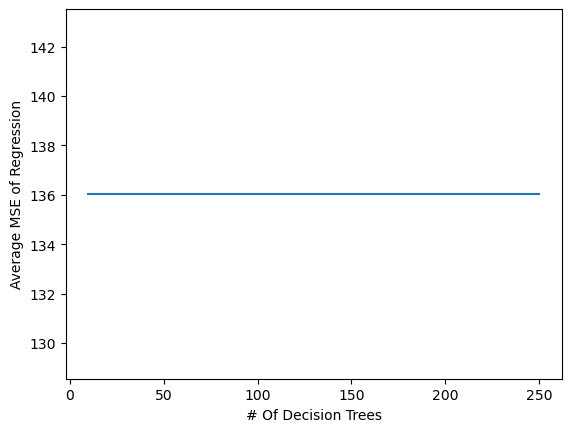

In [23]:
plt.plot([10,50,100,150,200,250], avgs_mses)
plt.ylabel("Average MSE of Regression")
plt.xlabel("# Of Decision Trees")
plt.show()

In [13]:
# Calculate the average predicted unit price and MSE for each product ID
product_avg_predicted_prices = defaultdict(list)
for entry in table_data:
    group_key = entry[0]
    avg_predicted_price = entry[2]
    avg_mse = entry[3]
    product_avg_predicted_prices[group_key].append((avg_predicted_price, avg_mse, entry[1]))

# Find the optimal prices for each product ID based on minimum average MSE
optimal_prices = {}
for group_key, avg_mse_list in product_avg_predicted_prices.items():
    min_avg_mse_entry = min(avg_mse_list, key=lambda x: x[1])
    optimal_price = min_avg_mse_entry[0]
    min_mse = min_avg_mse_entry[1]
    min_mse_sample = min_avg_mse_entry[2]
    optimal_prices[group_key] = (optimal_price, min_mse, min_mse_sample)

# Prepare the final table data for optimal prices
optimal_table_data = []
for group_key, (optimal_price, min_mse, min_mse_sample) in optimal_prices.items():
    optimal_table_data.append([group_key, optimal_price, min_mse, min_mse_sample])

# Print the table for optimal prices
optimal_table_headers = ["Product ID", "Optimal Price", "Min MSE", "Sample with Min MSE"]
print(tabulate(optimal_table_data, headers=optimal_table_headers, floatfmt=(".0f", ".2f", ".2f", ".0f")))


Product ID      Optimal Price    Min MSE    Sample with Min MSE
------------  ---------------  ---------  ---------------------
bed1                    39.99       0.00                     13
bed2                    89.90       0.00                      6
bed3                    88.24      11.15                     11
bed4                    47.90       0.00                     10
computers1              99.82       0.85                      6
computers2              78.98       1.17                     10
computers3             135.55       6.68                     10
computers4             150.29       0.09                     10
computers5              89.22       0.46                      7
computers6             149.90       0.00                      7
consoles1               35.66       0.29                     12
consoles2               22.15       5.50                      6
cool1                   99.99       0.00                      7
cool2                  129.99       0.00

## Neural Network

In [14]:
from sklearn.ensemble import RandomForestRegressor

# Define the window size
window_size = 5

grouped = retail_df.groupby('product_id')

table_data = []
mse_scores = []
predicted_unit_prices = []

for group_key, group_data in grouped:
    # set features and target variable
    features = group_data[['qty_sold', 'total_price', 'freight_price', 'product_rating',
                           'no_customers', 'seasonality', 'volume', 'comp1_price',
                           'comp1_prod_rating', 'comp1_freight_price', 'comp2_price',
                           'comp2_prod_rating', 'comp2_freight_price', 'comp3_price',
                           'comp3_prod_rating', 'comp3_freight_price', 'lag_price']]

    target = group_data['unit_price']
    
    num_samples = len(features)
    predicted_unit_prices = []
    
    # sliding window training and testing
    for i in range(window_size, num_samples):
        # Define the periods for training and testing
        train_start = i - window_size
        train_end = i
        test_start = i
        test_end = i + 1
        
        # Split data into training and testing sets
        features_train = features.iloc[train_start:train_end]
        target_train = target.iloc[train_start:train_end]
        features_test = features.iloc[test_start:test_end]
        target_test = target.iloc[test_start:test_end]
        
        # Train the model
        model = RandomForestRegressor(n_estimators=50, random_state=78)
        model.fit(features_train, target_train)
        
        # Make predictions
        y_pred = model.predict(features_test)
        
        # Evaluate using Mean Squared Error
        mse = mean_squared_error(target_test, y_pred)
        mse_scores.append(mse)
        
        # Calculate and store the predicted unit prices
        predicted_unit_price = y_pred[0]
        predicted_unit_prices.append(predicted_unit_price)
        
        table_data.append([group_key, i+1, predicted_unit_price, mse])

# Print table
table_headers = ["Product ID", "Sample", "Predicted Price", "MSE"]
print(tabulate(table_data, headers=table_headers, floatfmt=(".0f", ".0f", ".2f", ".2f")))

avg_mse = np.mean(mse_scores)
avg_predicted_unit_price = np.mean(predicted_unit_prices)
print(f"Average MSE: {avg_mse:.2f}")
print(f"Average Predicted Unit Price: {avg_predicted_unit_price:.2f}")

Product ID      Sample    Predicted Price       MSE
------------  --------  -----------------  --------
bed1                 6              45.95      0.00
bed1                 7              45.95     29.36
bed1                 8              45.73     32.99
bed1                 9              41.07      1.17
bed1                10              41.96      3.89
bed1                11              40.26      0.07
bed1                12              40.09      0.01
bed1                13              39.99      0.00
bed1                14              39.99      0.00
bed1                15              39.99      0.00
bed1                16              39.99      0.56
bed2                 6              89.90      0.00
bed2                 7              89.90      0.00
bed2                 8              89.90      0.00
bed2                 9              89.90      0.00
bed2                10              89.90      0.00
bed2                11              89.90      1.99
bed2        